In [6]:
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier 
import textdistance

# Configuration initiale de MLflow (facultatif)
import mlflow
mlflow.set_tracking_uri("workspace/ml_runs/")
experiment_name = "spacy_test"
mlflow.set_experiment(experiment_name)

# Configurer MLflow pour utiliser un dossier local pour le stockage


# Assurez-vous de créer le dossier s'il n'existe pas déjà



# Lecture des données
df = pd.read_excel("/workspace/DONNEE_LABEL_FAUX_REGROUPER.xlsx")
df2 = pd.read_excel("/workspace/DONNEE_LABEL_VRAI.xlsx")
# Votre prétraitement des données reste inchangé...
i = 4000
df = df.head(i)
# i est la ou je me suis arreté
# Renommer les colonnes par leur position
df = df.rename(columns={df.columns[0]: 'rue_init', df.columns[1]: 'PROP_LEV',df.columns[2]: 'LABEL'})
df = df.replace(np.nan, 0)
df['TYPE_VOIE'] =  df['rue_init'].str.split(' ').str[0]
df = df.replace(np.nan, 1)

df2 = df2.replace(np.nan, 1)
j = 1000
# i est la ou je me suis arreté
df2 = df2.head(j)
df2 = df2.rename(columns={df2.columns[0]: 'rue_init', df2.columns[1]: 'PROP_LEV',df2.columns[2]: 'LABEL'})

df2['TYPE_VOIE'] =  df2['rue_init'].str.split(' ').str[0]
df = pd.concat([df, df2], ignore_index=True)
df['rue_init'] = df['rue_init'].astype(str)
df['PROP_LEV'] = df['PROP_LEV'].astype(str)# Calculer des mesures de similarité
df["damerau_levenshtein"] = df.apply(lambda x: textdistance.damerau_levenshtein.normalized_similarity(x["rue_init"], x["PROP_LEV"]), axis=1)
df["jaro_winkler"] = df.apply(lambda x: textdistance.jaro_winkler(x["rue_init"], x["PROP_LEV"]), axis=1)
df["jaro"] = df.apply(lambda x: textdistance.jaro(x["rue_init"], x["PROP_LEV"]), axis=1)

# Calcul de la mesure de Sørensen-Dice pour chaque paire d'adresses
df['sorensen_dice'] = df.apply(lambda x: textdistance.sorensen_dice(x['rue_init'], x['PROP_LEV']), axis=1)

# Calcul de la plus longue sous-séquence commune (LCS) pour chaque paire d'adresses
df['lcs'] = df.apply(lambda x: textdistance.lcsstr.normalized_similarity(x['rue_init'], x['PROP_LEV']), axis=1)





In [7]:
import spacy
import textdistance

# Charger le modèle linguistique français
# Charger le modèle linguistique français medium
nlp = spacy.load("fr_core_news_lg")


# Fonction pour extraire le premier nom propre d'une chaîne de caractères
def extract_first_proper_noun(text):
    doc = nlp(text)
    proper_nouns = [token.text for token in doc if token.pos_ == "PROPN"]
    return " ".join(proper_nouns)


# Appliquer la fonction d'extraction sur 'rue_init' et 'PROP_LEV'
df['rue_init_name'] = df['rue_init'].apply(extract_first_proper_noun)
df['PROP_LEV_name'] = df['PROP_LEV'].apply(extract_first_proper_noun)

# Calculer la distance de Levenshtein et le score LCS sur les noms extraits
df["levenshtein_name_distance"] = df.apply(lambda x: textdistance.damerau_levenshtein.normalized_similarity(x["rue_init_name"], x["PROP_LEV_name"]), axis=1)
df["lcs_name_score"] = df.apply(lambda x: textdistance.lcsstr.normalized_similarity(x["rue_init_name"], x["PROP_LEV_name"]), axis=1)

# Mise à jour de l'ensemble des features pour inclure les nouvelles colonnes calculées
X = df[["damerau_levenshtein", "jaro_winkler", "jaro", "sorensen_dice", "lcs", "levenshtein_name_distance", "lcs_name_score"]]


In [8]:
df

,rue_init,PROP_LEV,LABEL,TYPE_VOIE,damerau_levenshtein,jaro_winkler,jaro,sorensen_dice,lcs,rue_init_name,PROP_LEV_name,levenshtein_name_distance,lcs_name_score
0,A RUE DE L ORMETEAU,AVENUE DE L EUROPE,0.0,A,0.473684,0.790100,0.766778,0.756757,0.421053,ORMETEAU,AVENUE EUROPE,0.153846,0.076923
1,A RUE DU CHEMIN DE FER,RUE LHOMOND,0.0,A,0.363636,0.530303,0.530303,0.484848,0.181818,FER,LHOMOND,0.000000,0.000000
2,A RUE DU DOCTEUR ROUX,BD DU COMTE DE MONTALEMBERT,0.0,A,0.296296,0.585538,0.585538,0.625000,0.148148,,BD COMTE,0.000000,0.000000
3,A/43 RUE JEAN BAPTISTE NOTTE,AVENUE JEAN BAPTISTE LEBAS,0.0,A/43,0.642857,0.677839,0.677839,0.740741,0.607143,A/43 JEAN BAPTISTE NOTTE,AVENUE JEAN BAPTISTE LEBAS,0.615385,0.576923
4,A1 ROUTE NATIONALE,RUE DU HAUIT,0.0,A1,0.222222,0.537037,0.537037,0.533333,0.111111,NATIONALE,,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,IMPASSE ARTHUR LEDENT,IMPASSE LEDENT,1.0,IMPASSE,0.666667,0.890476,0.817460,0.800000,0.380952,,LEDENT,0.000000,0.000000
4996,RUE D ORESMIEUX,ALLEE DES CERISIERS,0.0,RUE,0.368421,0.543080,0.543080,0.588235,0.157895,ORESMIEUX,ALLEE,0.111111,0.111111
4997,AVENUE PIERRE MENDES FRANCE,RUE ADRIEN DANVERS,0.0,AVENUE,0.296296,0.681327,0.681327,0.755556,0.111111,AVENUE FRANCE,ADRIEN,0.230769,0.153846
4998,AVENUE DU MARCHAL FOCH,AVENUE DU MARECHAL FOCH,1.0,AVENUE,0.956522,0.991304,0.985507,0.977778,0.565217,FOCH,FOCH,1.000000,1.000000


In [9]:
# Continuation du code précédent...

# Mise à jour de l'ensemble des features pour inclure les nouvelles colonnes calculées
# Assurez-vous que cette liste inclut toutes les features que vous souhaitez utiliser pour l'entraînement
features = ["damerau_levenshtein", "jaro_winkler", "sorensen_dice", "lcs", 
            "levenshtein_name_distance", "lcs_name_score"]
X = df[features]
y = df["LABEL"]

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=35)

# Entraînement du modèle XGBClassifier
model = XGBClassifier(use_label_encoder=False, eval_metric='error')
model.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluation du modèle
report = classification_report(y_test, y_pred, output_dict=True)
confusion = confusion_matrix(y_test, y_pred)

# Logging des métriques avec MLflow
with mlflow.start_run():
    mlflow.log_params({
        "i": len(df),
        "test_size": 0.1,
        "random_state": 35,
        # Ajoutez d'autres paramètres expérimentaux ici si nécessaire
    })
    
    # Log des métriques de performance
    mlflow.log_metric("precision", report['weighted avg']['precision'])
    mlflow.log_metric("recall", report['weighted avg']['recall'])
    mlflow.log_metric("f1-score", report['weighted avg']['f1-score'])

    # Log du modèle
    mlflow.sklearn.log_model(model, "model")

# Affichage du rapport de classification et de la matrice de confusion
print("Rapport de classification :")
print(classification_report(y_test, y_pred))
print("Matrice de confusion :")
print(confusion)


Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       365
         1.0       0.86      0.79      0.83       135

    accuracy                           0.91       500
   macro avg       0.89      0.87      0.88       500
weighted avg       0.91      0.91      0.91       500

Matrice de confusion :
[[348  17]
 [ 28 107]]


In [10]:
from sklearn.metrics import f1_score
import xgboost as xgb

def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    # Transformer les probabilités de prédiction en classe binaire (0 ou 1) basées sur un seuil (par exemple, 0.5)
    y_pred_binary = [int(value > 0.5) for value in y_pred]
    return 'f1', -f1_score(y_true, y_pred_binary)

model = XGBClassifier(use_label_encoder=False)

# Transformer les ensembles de données en DMatrix, format requis par XGBoost pour l'utilisation des callbacks personnalisés
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Paramètres pour XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False
}

# Entraînement du modèle avec le callback personnalisé pour F1
model = xgb.train(params, dtrain, evals=[(dtest, "test")], feval=f1_eval, maximize=True)


[0]	test-logloss:0.42847	test-f1:-0.00000


[1]	test-logloss:0.36198	test-f1:-0.59512
[2]	test-logloss:0.32114	test-f1:-0.71366
[3]	test-logloss:0.29361	test-f1:-0.74894
[4]	test-logloss:0.27612	test-f1:-0.76471
[5]	test-logloss:0.26790	test-f1:-0.76987
[6]	test-logloss:0.26154	test-f1:-0.77686


/home/vscode/.local/lib/python3.11/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:27:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	test-logloss:0.25716	test-f1:-0.78688
[8]	test-logloss:0.25401	test-f1:-0.79184
[9]	test-logloss:0.25068	test-f1:-0.79675


In [11]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, f1_score

# Définition de l'espace d'hyperparamètres à explorer
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
}

# Initialisation du classificateur XGBoost
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Définition du scorer F1 pour GridSearchCV
f1_scorer = make_scorer(f1_score)


In [12]:
# Configuration de GridSearchCV
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring=f1_scorer, cv=5, verbose=2)

# Entraînement
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.1s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=150; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_e

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [50, 100, 150]},
             scoring=make_scorer(f1_score, response_method='predict'),
             verbose=2)

In [13]:
print("Meilleurs hyperparamètres : ", grid_search.best_params_)
print("Meilleur score F1 : ", grid_search.best_score_)


Meilleurs hyperparamètres :  {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 150}
Meilleur score F1 :  0.854070265728825


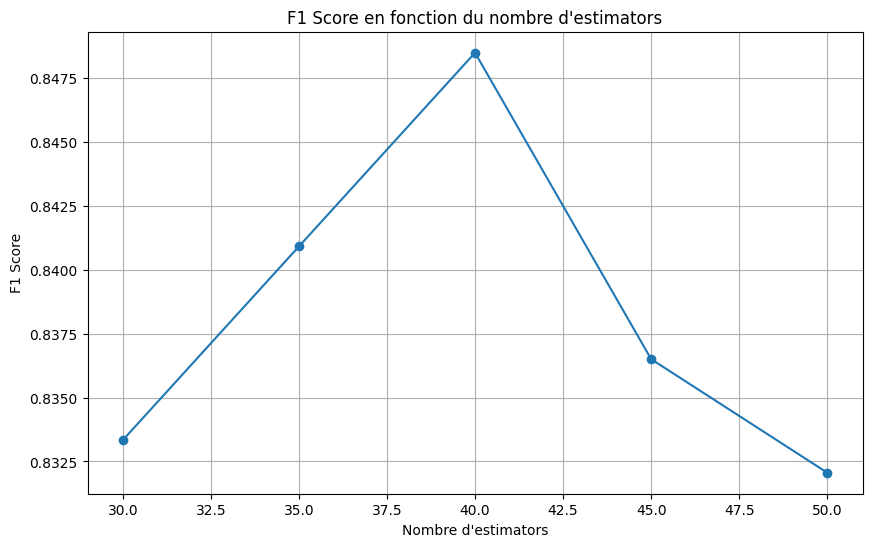

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt

# Supposons que X_train, X_test, y_train, y_test sont déjà définis
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_estimators_values = [30,35,40,45,50]
f1_scores = []

for n_estimators in n_estimators_values:
    model = XGBClassifier(n_estimators=n_estimators, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred)
    f1_scores.append(score)

# Tracer le graphique
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, f1_scores, marker='o', linestyle='-')
plt.title('F1 Score en fonction du nombre d\'estimators')
plt.xlabel('Nombre d\'estimators')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()


In [16]:
import optuna
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Supposons que X et y soient vos features et target
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    # Suggestion d'hyperparamètres
    n_estimators = trial.suggest_int('n_estimators', 35, 40)
    max_depth = trial.suggest_int('max_depth', 2, 25)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-8, 1.0)
    
    # Création et entraînement du modèle
    model = XGBClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate,
        use_label_encoder=False, 
        eval_metric='logloss'
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calcul du F1 score
    score = f1_score(y_test, y_pred)
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100) # Vous pouvez ajuster n_trials selon vos besoins

print("Nombre de trials terminés: ", len(study.trials))
print("Meilleur trial:")
trial = study.best_trial

print(" Valeur: ", trial.value)
print(" Hyperparamètres: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


/home/vscode/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-03-21 10:32:46,238] A new study created in memory with name: no-name-27ec20dc-9429-4dd3-ac52-d3b85583e8ef
/tmp/ipykernel_2842/1520897030.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-8, 1.0)
[I 2024-03-21 10:32:46,299] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 35, 'max_depth': 6, 'learning_rate': 0.0030175685238745314}. Best is trial 0 with value: 0.0.
/tmp/ipykernel_2842/1520897030.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remove

Nombre de trials terminés:  100
Meilleur trial:
 Valeur:  0.833976833976834
 Hyperparamètres: 
    n_estimators: 40
    max_depth: 15
    learning_rate: 0.32609828922050993


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import optuna

# Remplacez X et y par vos données
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', ['RandomForest', 'SVM', 'XGBoost'])
    
    if classifier_name == 'RandomForest':
        rf_n_estimators = trial.suggest_int('rf_n_estimators', 10, 100)
        model = RandomForestClassifier(n_estimators=rf_n_estimators)
        
    elif classifier_name == 'SVM':
        svm_c = trial.suggest_float('svm_c', 1e-10, 1e10, log=True)
        model = SVC(C=svm_c, gamma='auto')
        
    else: # XGBoost
        xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 35, 40)
        xgb_max_depth = trial.suggest_int('xgb_max_depth', 2, 25)
        xgb_learning_rate = trial.suggest_loguniform('xgb_learning_rate', 1e-8, 1.0)
        model = XGBClassifier(
            n_estimators=xgb_n_estimators,
            max_depth=xgb_max_depth,
            learning_rate=xgb_learning_rate,
            use_label_encoder=False,
            eval_metric='logloss'
        )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred)
    
    return score


In [ ]:
"""study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Nombre de trials terminés: ", len(study.trials))
print("Meilleur trial:")
trial = study.best_trial

print(" Valeur: ", trial.value)
print(" Hyperparamètres: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")"""


'study = optuna.create_study(direction=\'maximize\')\nstudy.optimize(objective, n_trials=50)\n\nprint("Nombre de trials terminés: ", len(study.trials))\nprint("Meilleur trial:")\ntrial = study.best_trial\n\nprint(" Valeur: ", trial.value)\nprint(" Hyperparamètres: ")\nfor key, value in trial.params.items():\n    print(f"    {key}: {value}")'